In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kasturishirole","key":"e19ff8dfb14c51c199d00f4b4e446103"}'}

In [4]:
# Make a hidden directory for Kaggle API keys
!mkdir -p ~/.kaggle

# Move the kaggle.json file to this directory
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Replace the dataset name below with the exact Kaggle dataset identifier
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 723MB/s]


In [6]:
# Unzip the downloaded file
!unzip brain-mri-images-for-brain-tumor-detection.zip -d brain_mri_dataset

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_mri_dataset/brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_mri_dataset/brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_

In [7]:
# Check the folder structure
import os
os.listdir("brain_mri_dataset")

['yes', 'no', 'brain_tumor_dataset']

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [9]:
from PIL import Image

In [10]:
# Initialize lists
data = [] # for storing images
paths = [] # for storing paths
result = []

# Setup the encoder for labels (0: tumor, 1: no tumor)
encoder = OneHotEncoder()
encoder.fit([[0], [1]])  # 0: tumor (yes), 1: no tumor (no)

# Collect image paths from the 'yes' (tumor) folder
for r, d, f in os.walk('./brain_mri_dataset/yes'):
    for file in f:
        if file.endswith('.jpg'):
            paths.append(os.path.join(r, file))

# Process each image
for path in paths:
    img = Image.open(path)
    img = img.resize((128, 128)) # all images to be of same size
    img = np.array(img)
    if img.shape == (128, 128, 3):  # Only accept RGB images
        data.append(img)
        result.append(encoder.transform([[0]]).toarray())  # 0 for tumor

In [12]:
# For 'no tumor' images
paths = []
for r, d, f in os.walk('./brain_mri_dataset/no'):
    for file in f:
        if file.endswith('.jpg'):
            paths.append(os.path.join(r, file))
            img = Image.open(os.path.join(r, file))
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(img)
                result.append(encoder.transform([[1]]).toarray())  # 1 for no tumor

In [13]:
data = np.array(data)
data.shape

(208, 128, 128, 3)

In [14]:
print(f'Total number of images we have: {len(data)}')

Total number of images we have: 208


In [15]:
result = np.array(result)
result = result.reshape(208,2)

In [16]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

In [17]:
print(f'Number of images in training data: {len(x_train)}')

Number of images in training data: 166


In [18]:
print(f'Number of images in testing data: {len(x_test)}')

Number of images in testing data: 42


# **Building CNN**

In [19]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization()) # to standard the output to a common scale
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # to prevent overfitting

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,585,602 (128.12 MB)

 Trainable params: 33,585,410 (128.12 MB)

 Non-trainable params: 192 (768.00 B)

None


In [20]:
y_train.shape

(166, 2)

# **Model Evaluation**

In [21]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - loss: 25.9559 - val_loss: 31.3134
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - loss: 4.2346 - val_loss: 15.0091
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - loss: 2.8014 - val_loss: 3.7704
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - loss: 1.0054 - val_loss: 11.4342
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - loss: 0.4800 - val_loss: 6.3797
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - loss: 0.9919 - val_loss: 2.6980
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.4084 - val_loss: 3.8492
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - loss: 0.3633 - val_loss: 5.1191
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - loss: 0.3561 - val_loss: 3.4515
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - loss: 0.0374 - val_loss: 2.1915
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - loss: 0.0330 - val_loss: 1.9440
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - loss: 0.0431 - val_loss: 2.1585
Epoch 13/

# **Plotting losses**

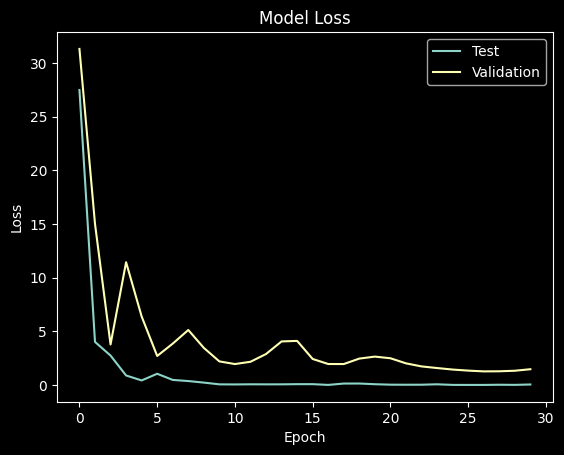

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

# **Testing the model**

In the testing phase of our machine learning project, we evaluate the model's performance using new images it hasn't seen before. The code snippet demonstrates how to test the model with an MRI image that has a tumor and one which does not have a tumor.

The process involves loading the image, resizing it to match the input size the model expects, and then reshaping it to the appropriate format for the model to process. The model then predicts whether a tumor is present or not.

The result, displayed below the image, shows the model's confidence level in its prediction. In both cases, we see that the model correctly classifies a "non-tumor" image as "not a tumor" and a "tumor" image as a "tumor" image.

This means that our model is trained successfully now!

In [23]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

99.99292% Confidence This Is No, Its not a tumor


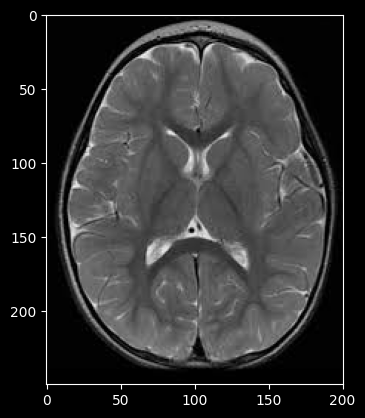

In [29]:
from matplotlib.pyplot import imshow
# Load and preprocess image
img_path = './brain_mri_dataset/no/N5.jpg'
img = Image.open(img_path)
x = np.array(img.resize((128, 128)))
x = x.reshape(1, 128, 128, 3)
# Predict
res = model.predict_on_batch(x)
# Determine classification index
classification = np.argmax(res)
# Display image
imshow(img)
# Print result
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

100.00% Confidence This Is A Its a Tumor


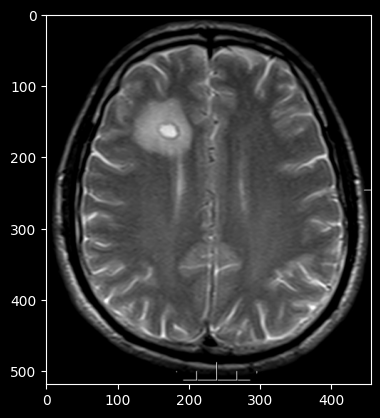

In [26]:
from matplotlib.pyplot import imshow
# Load image from the correct Kaggle-downloaded path
img = Image.open('./brain_mri_dataset/yes/Y3.jpg')
# Preprocess the image
x = np.array(img.resize((128, 128)))
x = x.reshape(1, 128, 128, 3)
# Make prediction
res = model.predict_on_batch(x)
# Get class index with highest confidence
classification = np.argmax(res)
# Display the image
imshow(img)
# Print confidence and classification
print(f"{res[0][classification]*100:.2f}% Confidence This Is A {names(classification)}")

# Provide a title for your app:

In [30]:
#@title Provide a title for your app:
heading_title = "Kasturi's brain tumor classification app" # @param {type:"string"}

You can add some example images that you want to be present in your app by default. The user can see use these images to quickly and easily test the model. How many example images do you want to load?

In [31]:
#@title You can add some example images that you want to be present in your app by default. The user can see use these images to quickly and easily test the model. How many example images do you want to load?
num_examples = 2 # @param {type:"slider", min:1, max:6, step:1}

Enter the paths for the example images that you want displayed in your app by default. The user can use these images to quickly and easily test the model. Note: You can get the path for the file from the left sidebar. Simply run the code below, select the image file you want to include from its folder, right-click and select 'Copy path'. Then paste the path in the input box displayed:


example_path_1:  ./brain_mri_dataset/no/N5.jpg
example_path_2:  ./brain_mri_dataset/yes/Y3.jpg


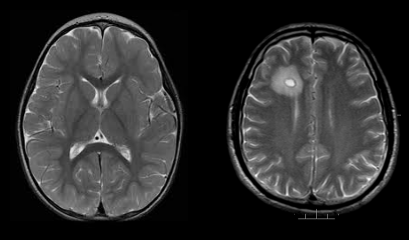

In [32]:
#@title Enter the paths for the example images that you want displayed in your app by default. The user can use these images to quickly and easily test the model. Note: You can get the path for the file from the left sidebar. Simply run the code below, select the image file you want to include from its folder, right-click and select 'Copy path'. Then paste the path in the input box displayed:
from matplotlib import pyplot as plt
from PIL import Image

examples=[]
for i in range(num_examples):
  example_path = input(f"example_path_{i+1}:  ")
  examples.append(example_path)

#Displaying the selected images side by side
rows = 1
plt.figure(figsize=(16, 8))
for num, x in enumerate(examples):
    img = Image.open(x)
    plt.subplot(rows,6,num+1)
   # plt.title(x.split('.')[0])
    plt.axis('off')
    plt.imshow(img)

You can also add some description and explanation to your app's interace if you want. Go ahead and specify some text for the description and the long description (if you want to):

In [33]:
#@title You can also add some description and explanation to your app's interace if you want. Go ahead and specify some text for the description and the long description (if you want to):
desc = "Brain tumor app. Let's learn!" # @param {type:"string"}
long_desc = "Select an image or upload one to predict if brain tumor is present or not" # @param {type:"string"}

Select a Theme for Gradio Interface:

In [34]:
import gradio as gr

#@title Select a Theme for Gradio Interface:
theme_selection = "Glass" # @param ["Base", "Default", "Glass", "Monochrome", "Soft"]

theme_dict = {
    "Base": gr.themes.Base(),
    "Default": gr.themes.Default(),
    "Glass": gr.themes.Glass(),
    "Monochrome": gr.themes.Monochrome(),
    "Soft": gr.themes.Soft()
}

# The selected theme is determined by the user's dropdown selection
selected_theme = theme_dict[theme_selection]

# Now you can use the selected_theme variable when you create your Gradio interface

In [35]:
def recognize_image(image):
    # Resize the image to the expected dimensions
    img = Image.fromarray(image).resize((128, 128))
    # Convert the image to a NumPy array
    x = np.array(img)
    # Reshape the image to match the model input
    x = x.reshape(1, 128, 128, 3)

    # Make a prediction
    res = model.predict_on_batch(x)
    classification = np.where(res == np.amax(res))[1][0]

    # Map the class index to the actual class name (assuming you have a list of class names)
    class_names = ['No Tumor', 'Tumor']  # Example class names, update according to your model
    result = f"{names(classification)}"

    return result

In [36]:
# Assuming recognize_image, examples, heading_title, desc, long_desc, and selected_theme are defined elsewhere.

# Update the import for components
image = gr.Image()
label = gr.Label()

# Create the interface with the updated component imports
iface = gr.Interface(
    fn=recognize_image,
    inputs=image,
    outputs=label,
    examples=examples,
    title=heading_title,
    description=desc,
    article=long_desc,
    theme=selected_theme  # Make sure this is defined based on user selection as explained in previous messages
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4e2a6cd2c49a05f83e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4e2a6cd2c49a05f83e.gradio.live
